This notebook contains cell type labelling for the pbmc along with marker gene evidence. It contains code for picking out the final clusters we used, and plots of marker genes used. In practice, deciding on which clusters to use is a much more iterative process.

*Note:* This notebook requires on some files in `./data`, which would be downloaded by running `pbmc-overview.ipynb`.

In [1]:
import h5py
from matplotlib import pyplot as plt
from natsort import natsorted
import numpy as np
import pandas as pd
import scanpy as sc

from constclust import reconcile, ComponentList

In [2]:
plt.rcParams["figure.figsize"] = (4, 4)
plt.rcParams["figure.dpi"] = 120

# Loading

In [3]:
def read_results(pth) -> "Tuple[pd.DataFrame, pd.DataFrame]":
    """Read params and clusterings which have been stored to disk."""
    with h5py.File(pth, "r") as f:
        params_group = f["params"]
        params = pd.DataFrame(
            {
                col: params_group[col]
                for col in ["n_neighbors", "resolution", "random_state"]
            }
        )
        cluster_group = f["clusterings"]
        clusterings = pd.DataFrame(
            cluster_group["clusterings"][()],
            index=cluster_group["obs_names"].asstr()[:],
        )
    return params, clusterings

In [4]:
pbmc = sc.read("data/pbmc-labelled.h5ad")

In [5]:
params, clusterings = read_results("data/pbmc-clusterings.h5")

In [6]:
rec = reconcile(params, clusterings)
comps = ComponentList(rec.get_components(0.9, min_cells=5))

# Picking groups

This just contains minimal code for how clusters were ulimately assigned. Marker genes and differential expression follows.

In [7]:
def calc_freq(comp) -> pd.Series:
    """Frequency cell was included per component"""
    from collections import Counter
    from itertools import chain

    rec = comp._parent
    samples_idx = rec.clusterings.index
    s = pd.Series(np.zeros(len(samples_idx)), index=samples_idx)
    c = Counter(chain.from_iterable(rec._mapping.iloc[comp.cluster_ids].values))
    s.iloc[list(c.keys())] += list(c.values())
    return s

In [8]:
def make_labelling(components: ComponentList, min_inclusion: float = 0.9) -> pd.Series:
    """Given a set of components, return a flat labelling.

    Params
    ------
    components
        The components to use
    min_inclusion
        How freuntly did an observation have to show up in the clusters for a components to be labelled.
    """
    freqs = pd.DataFrame(
        {
            str(k): calc_freq(comp) / len(comp)
            for k, comp in components.components.items()
        }
    )
    labels = freqs.idxmax(1)
    labels[freqs.max(1) < min_inclusion] = "None"
    return labels.astype(
        pd.CategoricalDtype(
            natsorted(pd.unique(labels)),
        )
    )

In [9]:
clusters_lowlevel = [
    # Leukocytes
    28, 40, 31, 8, 37, 26, 23, 21,
    24, # 24 could be broken down into 17, 25, but not sure what to label them as
    # NK
    39, 46,
    # B
    13, 16, 11, 9,
    # Mono
    5, 3, 2, 1, # 6 is activated
]

pbmc.obs["lowlevel"] = make_labelling(comps[clusters_lowlevel])
pbmc.uns["lowlevel_colors"] = [
    '#1f77b4',
    '#ff7f0e',
    '#279e68',
    '#d62728',
    '#aa40fc',
    '#8c564b',
    '#e377c2',
    '#b5bd61',
    '#17becf',
    '#aec7e8',
    '#ffbb78',
    '#98df8a',
    '#ff9896',
    '#c5b0d5',
    '#c49c94',
    '#f7b6d2',
    '#dbdb8d',
    '#9edae5',
    'lightgray'
]

In [10]:
clusters_highlevel = [0, 2, 4, 15]
pbmc.obs["highlevel"] = make_labelling(comps[clusters_highlevel], 0)
pbmc.uns["highlevel_colors"] = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728"]

# Assigning cell types

# High level

In [11]:
highlevel_markers = {}

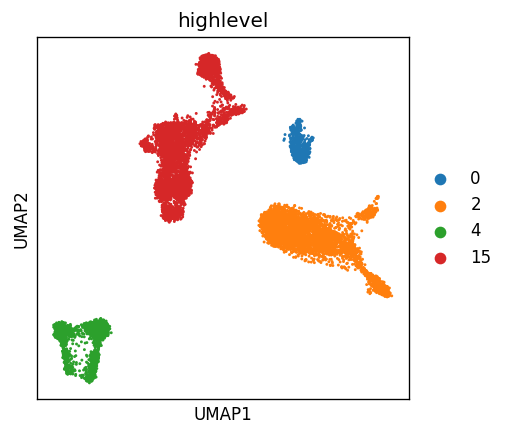

In [12]:
sc.pl.umap(pbmc, color="highlevel")

## Monocytes

In [13]:
highlevel_markers["Monocytes"] = [
    "CD14"
]

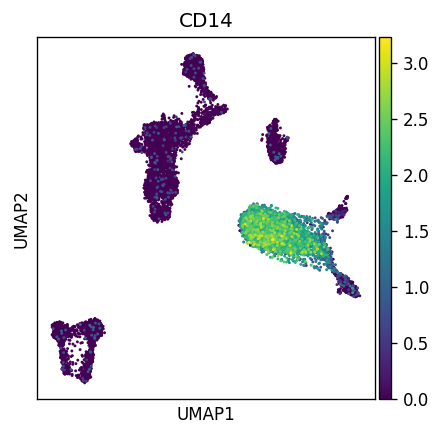

In [14]:
sc.pl.umap(pbmc, color=highlevel_markers["Monocytes"])

## NK Cells

In [15]:
highlevel_markers["NK Cells"] = [
    "NCAM1",
    "FCGR3A",
]

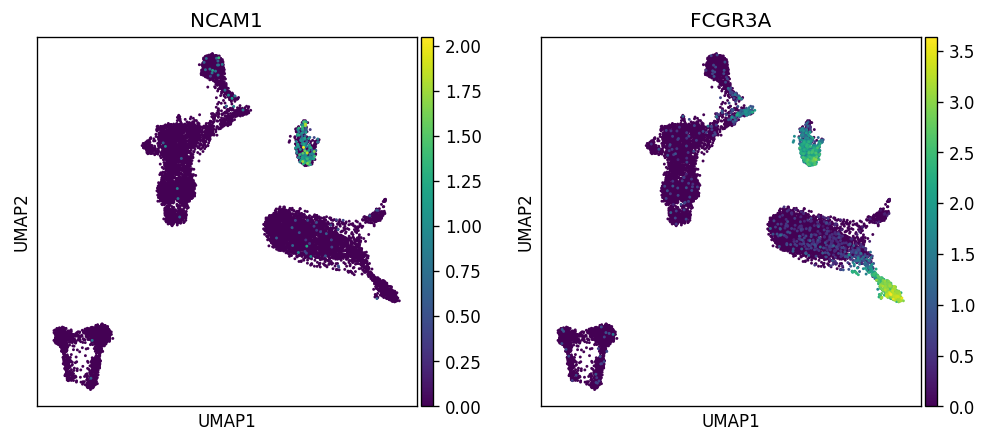

In [16]:
# FCGR3A: CD16, but this also is used to mark non-classical monocytes
sc.pl.umap(pbmc, color=highlevel_markers["NK Cells"])

## T-cells

In [17]:
highlevel_markers["T Cells"] = [
    "CD3D",
    "CD3E",
    "CD3G",
    "CD4",
    'CD8A',
    'CD8B',
]

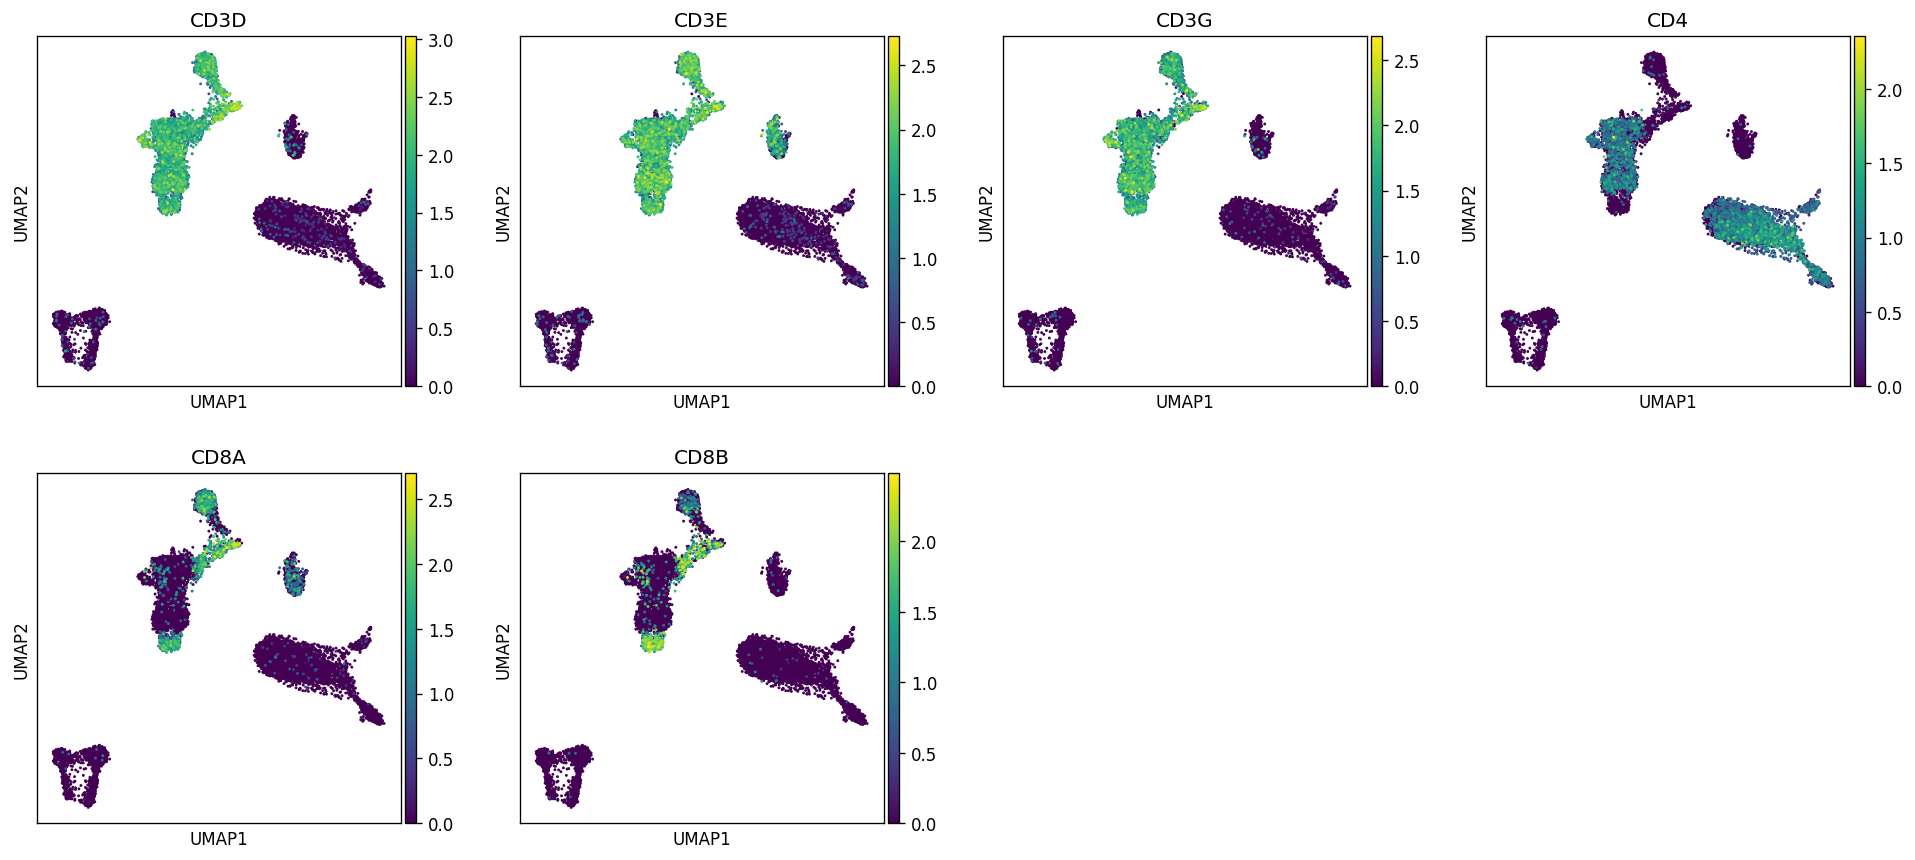

In [18]:
sc.pl.umap(pbmc, color=highlevel_markers["T Cells"])

## B-cells

In [19]:
highlevel_markers["B Cells"] = [
    "CD19",
]

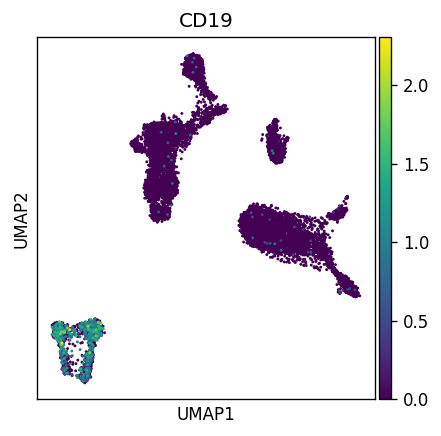

In [20]:
sc.pl.umap(pbmc, color="CD19")

## Assigning

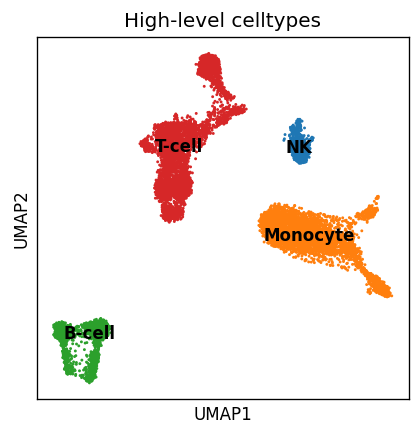

In [21]:
pbmc.obs["High-level celltypes"] = pbmc.obs["highlevel"].map(
    {
        "0": "NK",
        "2": "Monocyte",
        "4": "B-cell",
        "15": "T-cell",
    }
)
sc.pl.umap(pbmc, color="High-level celltypes", legend_loc="on data")

# Lowlevel

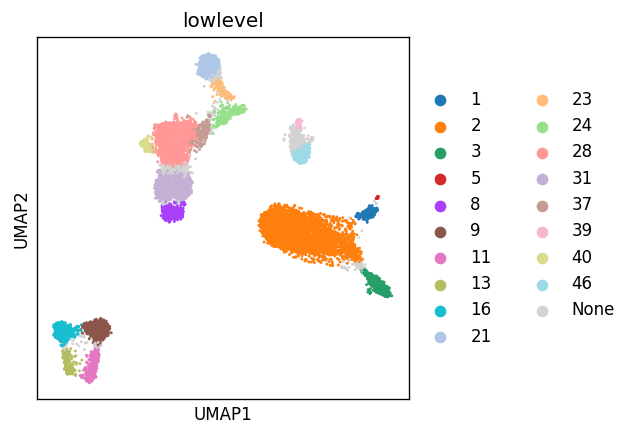

In [22]:
sc.pl.umap(pbmc, color="lowlevel")

In [23]:
lowlevel_markers = {}

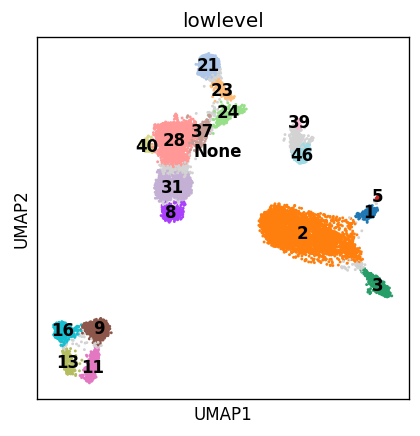

In [24]:
sc.pl.umap(pbmc, color="lowlevel", legend_loc="on data")

In [25]:
lowlevel_mapping = {"None": "None"}

## Monocytes

In [26]:
monocytes = pbmc[pbmc.obs["High-level celltypes"] == "Monocyte"].copy()

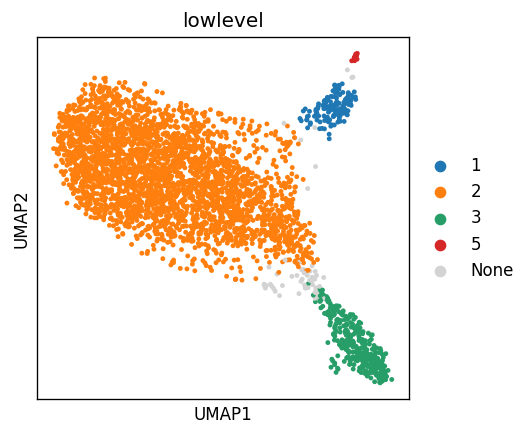

In [27]:
sc.pl.umap(monocytes, color="lowlevel")

### Classical

In [28]:
lowlevel_markers["Classical Monocyte"] = ["CD14"]

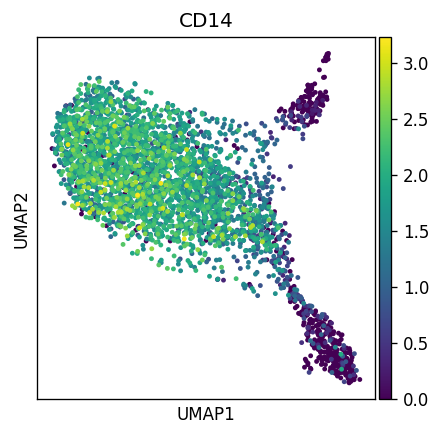

In [29]:
sc.pl.umap(monocytes, color=lowlevel_markers["Classical Monocyte"])

In [30]:
lowlevel_mapping["2"] = "Classical Monocyte"

### Non classical

In [31]:
lowlevel_markers["Non-classical Monocyte"] = [
    "FCGR3A", # AKA CD16
    "CD14",
]

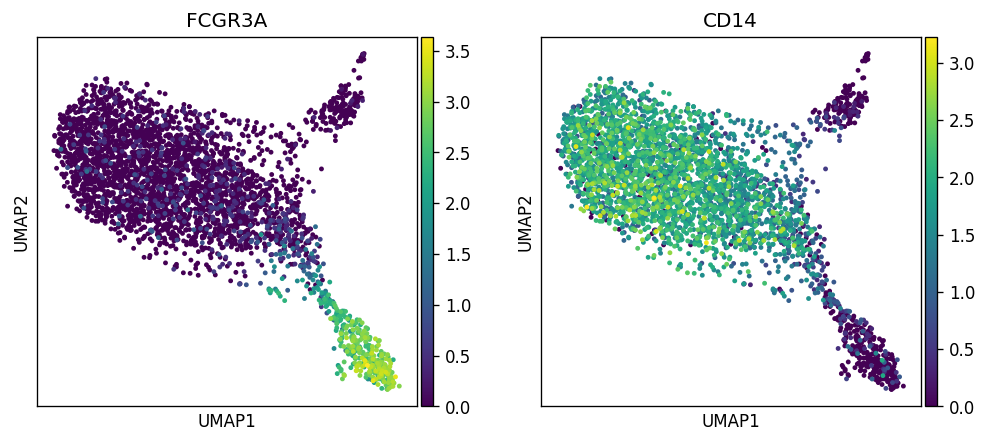

In [32]:
sc.pl.umap(monocytes, color=lowlevel_markers["Non-classical Monocyte"]) # CD16+, CD14-

In [33]:
lowlevel_mapping["3"] = "Non-classical Monocyte"

### Dendritic Cell

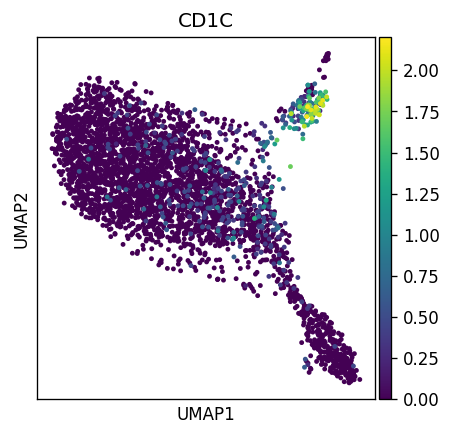

In [34]:
lowlevel_markers["Dendritic Cell"] = [
    "CD1C"
]
sc.pl.umap(monocytes, color=lowlevel_markers["Dendritic Cell"])

In [35]:
lowlevel_mapping["1"] = "Dendritic Cell"

### Clec9a DC

CLEC9A and BDCA3 (THBD) expression https://www.ncbi.nlm.nih.gov/pubmed/20479116. It's also component #5

In [36]:
lowlevel_markers["CLEC9A Dendritic Cell"] = [
    "CLEC9A", 
    "THBD"
]

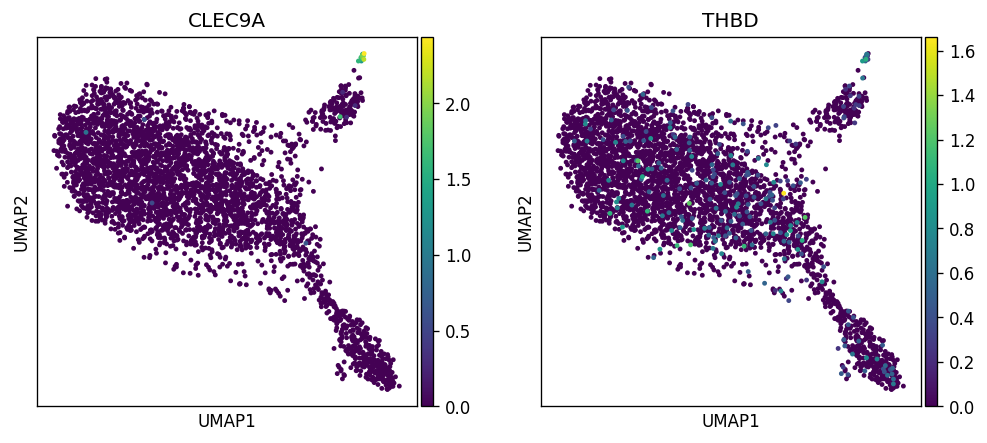

In [37]:
# THBD is CD141
sc.pl.umap(monocytes, color=lowlevel_markers["CLEC9A Dendritic Cell"])

In [38]:
lowlevel_mapping["5"] = "CLEC9A Dendritic Cell"

## NK Cells

In [39]:
nkcells = pbmc[pbmc.obs["High-level celltypes"] == "NK"].copy()

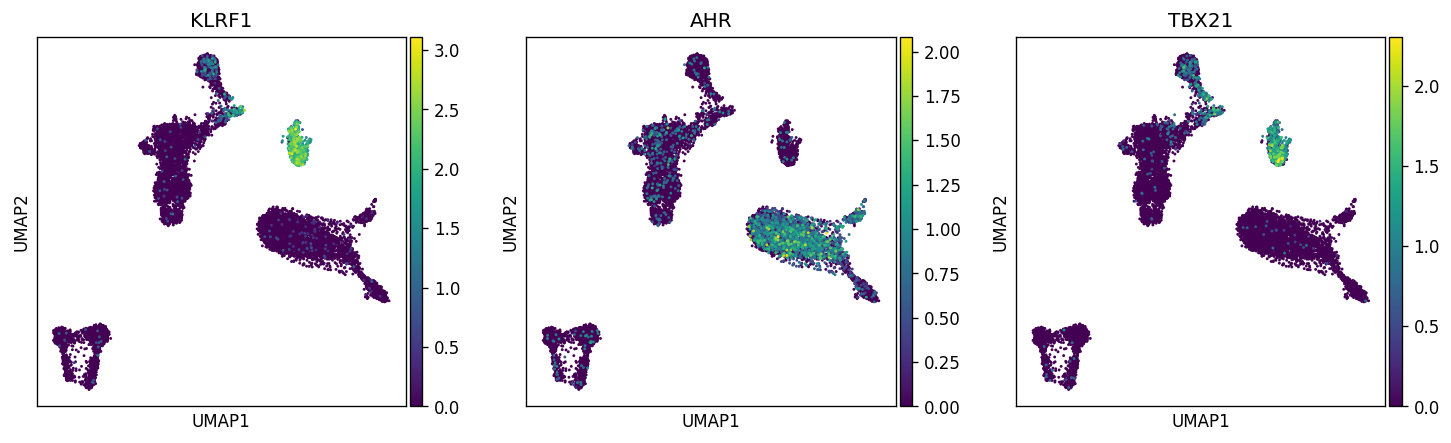

In [40]:
sc.pl.umap(pbmc, color=["KLRF1", "AHR", "TBX21"])

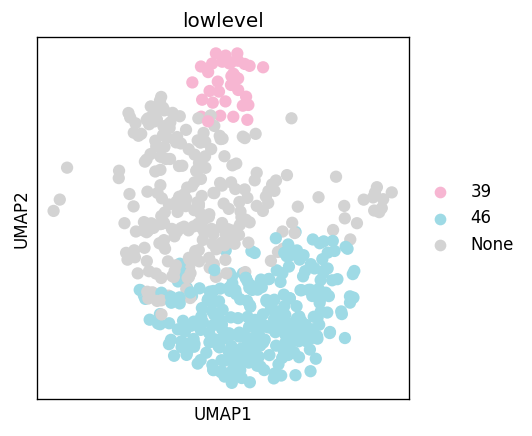

In [41]:
sc.pl.umap(nkcells, color="lowlevel")

In [42]:
# https://dx.doi.org/10.4049%2Fjimmunol.1701128
lowlevel_markers["Stage 4 NK Cells"] = [
    "FCGR3A", # # CD16
    "NCAM1", # CD56
]
lowlevel_markers["Stage 5 NK Cells"] = [
    "FCGR3A", # CD16
]

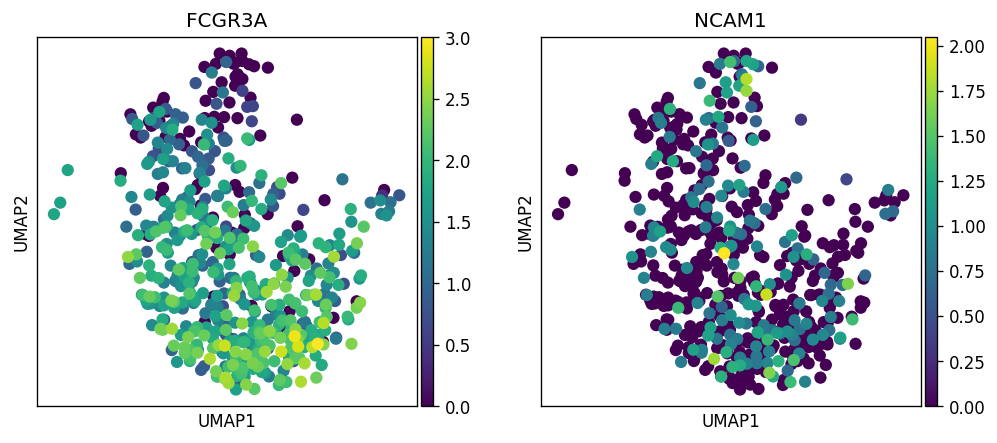

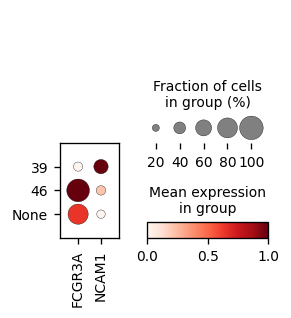

In [43]:
sc.pl.umap(nkcells, color=lowlevel_markers["Stage 4 NK Cells"])
sc.pl.dotplot(nkcells, lowlevel_markers["Stage 4 NK Cells"], groupby="lowlevel", standard_scale="var")

In [44]:
lowlevel_mapping["39"] = "Stage 4 NK Cells"
lowlevel_mapping["46"] = "Stage 5 NK Cells"

## T-Cells

In [45]:
tcells = pbmc[pbmc.obs["High-level celltypes"] == "T-cell"].copy()

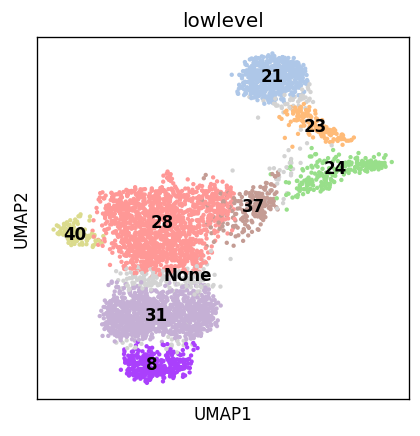

In [46]:
sc.pl.umap(tcells, color="lowlevel", legend_loc="on data")

### Fox3p Tregs

In [47]:
lowlevel_markers["FOXP3+ T Regulatory Cells"] = [
    "FOXP3", 
    "CD4", 
    "IL2RA",  # CD25 is IL2RA + IL2RB
    "IL2RB",
]

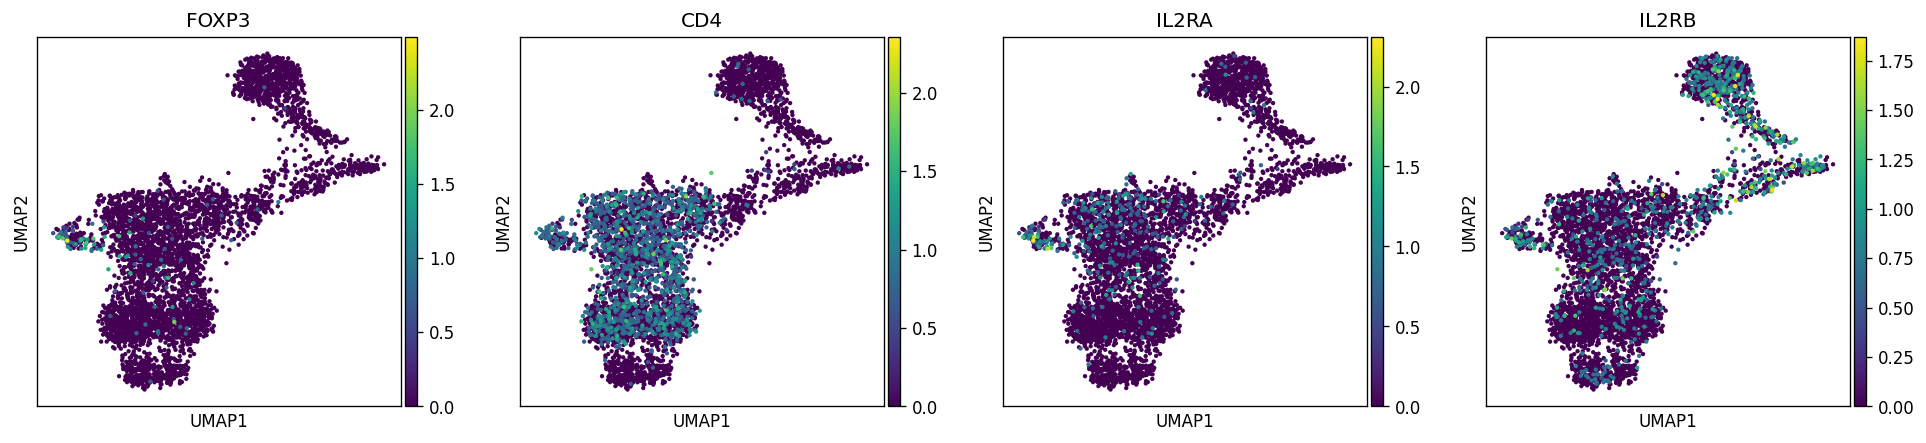

In [48]:
# CD25: IL2RA + IL2RB
sc.pl.umap(tcells, color=lowlevel_markers["FOXP3+ T Regulatory Cells"])

In [49]:
lowlevel_mapping["40"] = "FOXP3+ T Regulatory Cells"

### CD8+ Naive T cells?

Used to think they were CD8+ Memory T Cells, but my presumption is you can't be memory and naive.

* Information that could help here, is whether CD45RO vs CD45RA is expressed, but those are isoforms
* Don't have CCL5, which is turned on after activation

In [50]:
lowlevel_markers["CD8+ Naive T Cells"] = [
    "CD8A",
    "CD248",
    "CCR7",
    "IL7R",
    "CCL5",
]

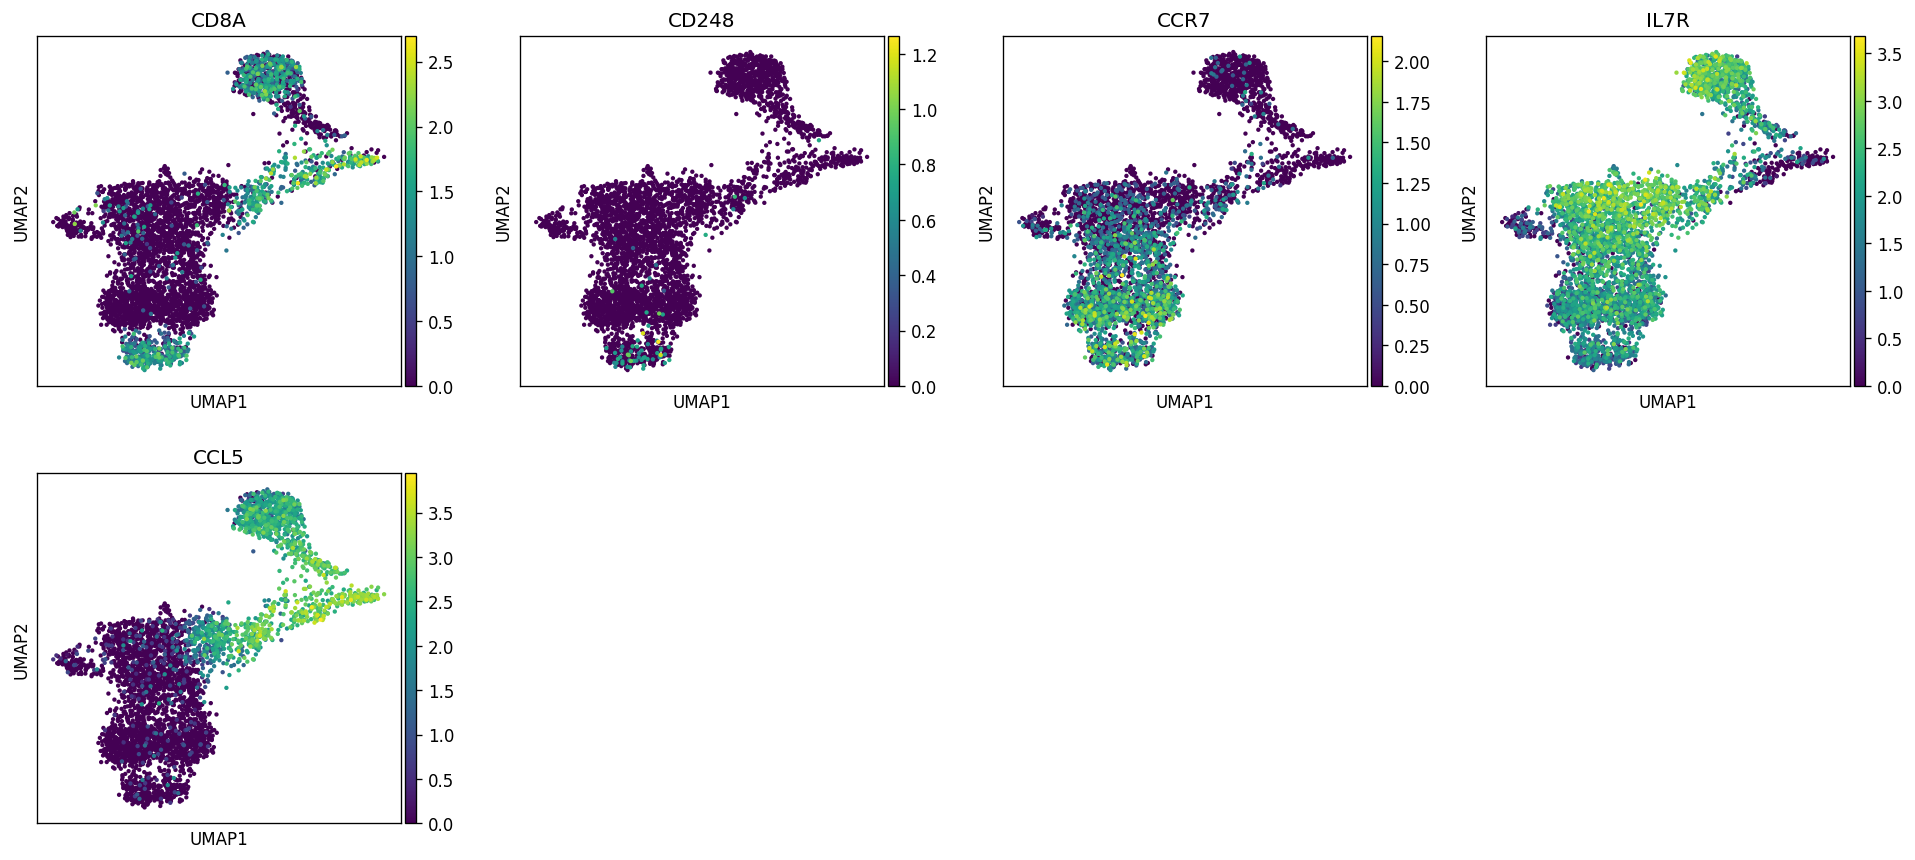

In [51]:
sc.pl.umap(tcells, color=lowlevel_markers["CD8+ Naive T Cells"])

In [52]:
lowlevel_mapping["8"] = "CD8+ Naive T Cells"

## CD8 memory cells, exhaustion (maybe not though)

* IFNG should decrease with exhaustion?
* Sell (l-selectin, cd62l) should be down from naive
* IL7R should also go down with exhaustion, so should IL2
* TBX21 (T-bet) is anticorrelated with IL7R in CD8 cells


CD8 memory activation. Left has IL7R so it can still proliferate, but right has IFNG which looks like activation. Both have CCL5, so they have been activated

In [53]:
lowlevel_markers["CD8+ Memory Cells"] = [
    "CD8A", "CCL5", "SELL", "IL7R"
]
lowlevel_markers["CD8+ Activated Memory Cells"] = [
    "CD8A", "IFNG", "CCL5", "TBX21"
]

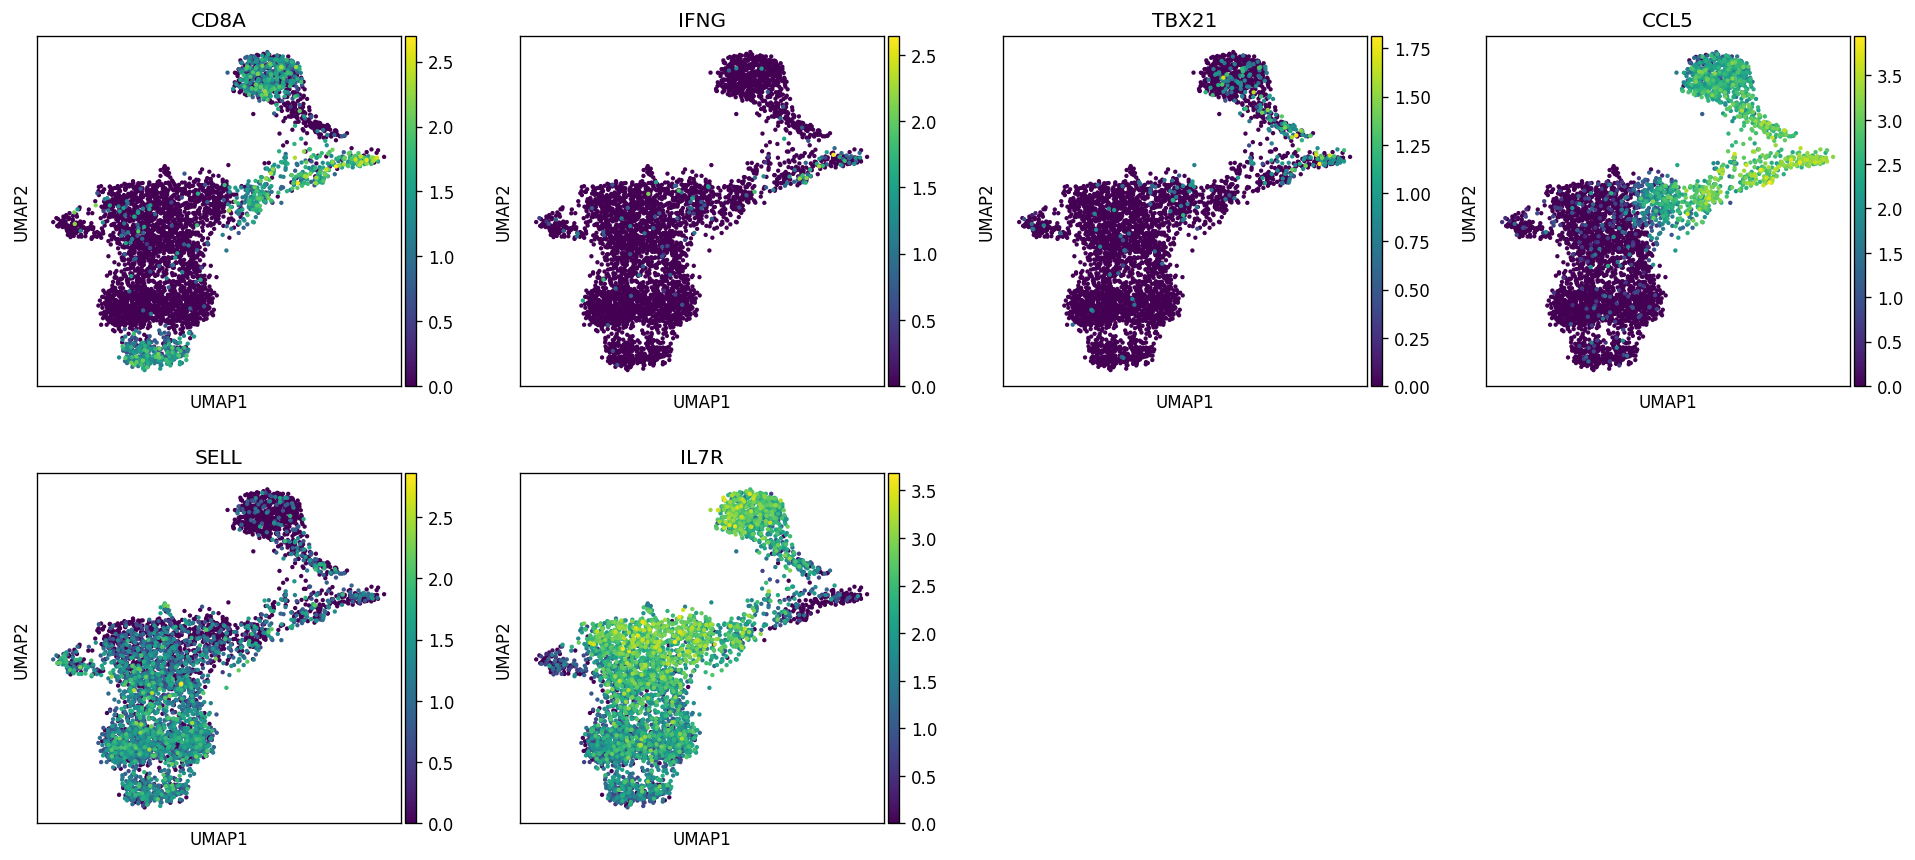

In [54]:
sc.pl.umap(
    tcells,
    color=list(
        set(
            lowlevel_markers["CD8+ Memory Cells"]
        ).union(
            set(lowlevel_markers["CD8+ Activated Memory Cells"])
        )
    )
)

In [55]:
lowlevel_mapping["37"] = "CD8+ Memory Cells"
lowlevel_mapping["24"] = "CD8+ Activated Memory Cells"
# lowlevel_mapping["25"] = "CD8+ Activated Memory Cells (1)"
# lowlevel_mapping["17"] = "CD8+ Activated Memory Cells (2)"

## CD8+ Rorc+ Tc17 T cells

* Shoud these be Tc17?

In [56]:
lowlevel_markers["CD8+ Rorc+ Tc17 T Cells"] = [
    "KLRB1",
    "TBX21",
    "RORC",
    "IL23R",
    "CCR6"
]

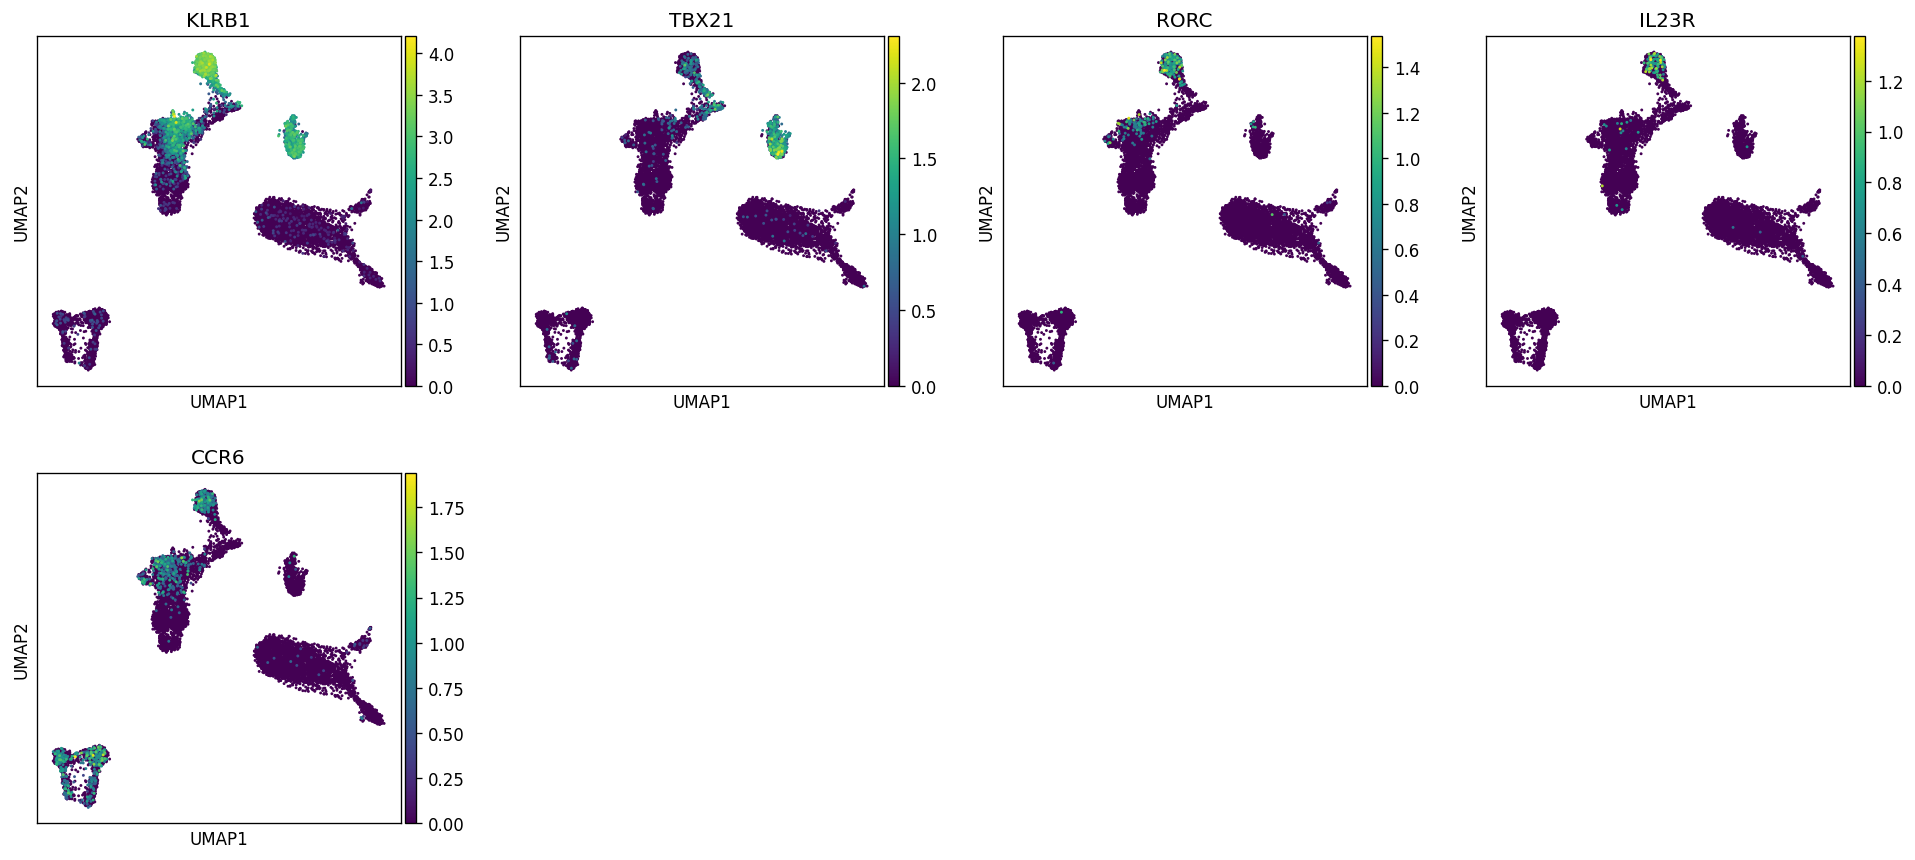

In [57]:
sc.pl.umap(pbmc, color=lowlevel_markers["CD8+ Rorc+ Tc17 T Cells"])

In [58]:
lowlevel_mapping["21"] = "CD8+ Rorc+ Tc17 T Cells"

### Memory T-cells

In [59]:
lowlevel_markers["T Effector Cells"] = [
    "PTPRC", # CD45RO+
    "CD4", #CD4+
#     "CCR7", # Memory cells should be CCR7-
    "ANXA1", # Memory +
    "IL32",
    "S100A4",
    "S100A11",
]
lowlevel_markers["CD4+ Naive T Cells"] = [
    "PTPRC", # CD45RO+
    "CD4", #CD4+
    "CCR7", # Memory cells should be CCR7-
#     "ANXA1", # Memory +
    "IL32",
#     "S100A4",
#     "S100A11",   
]

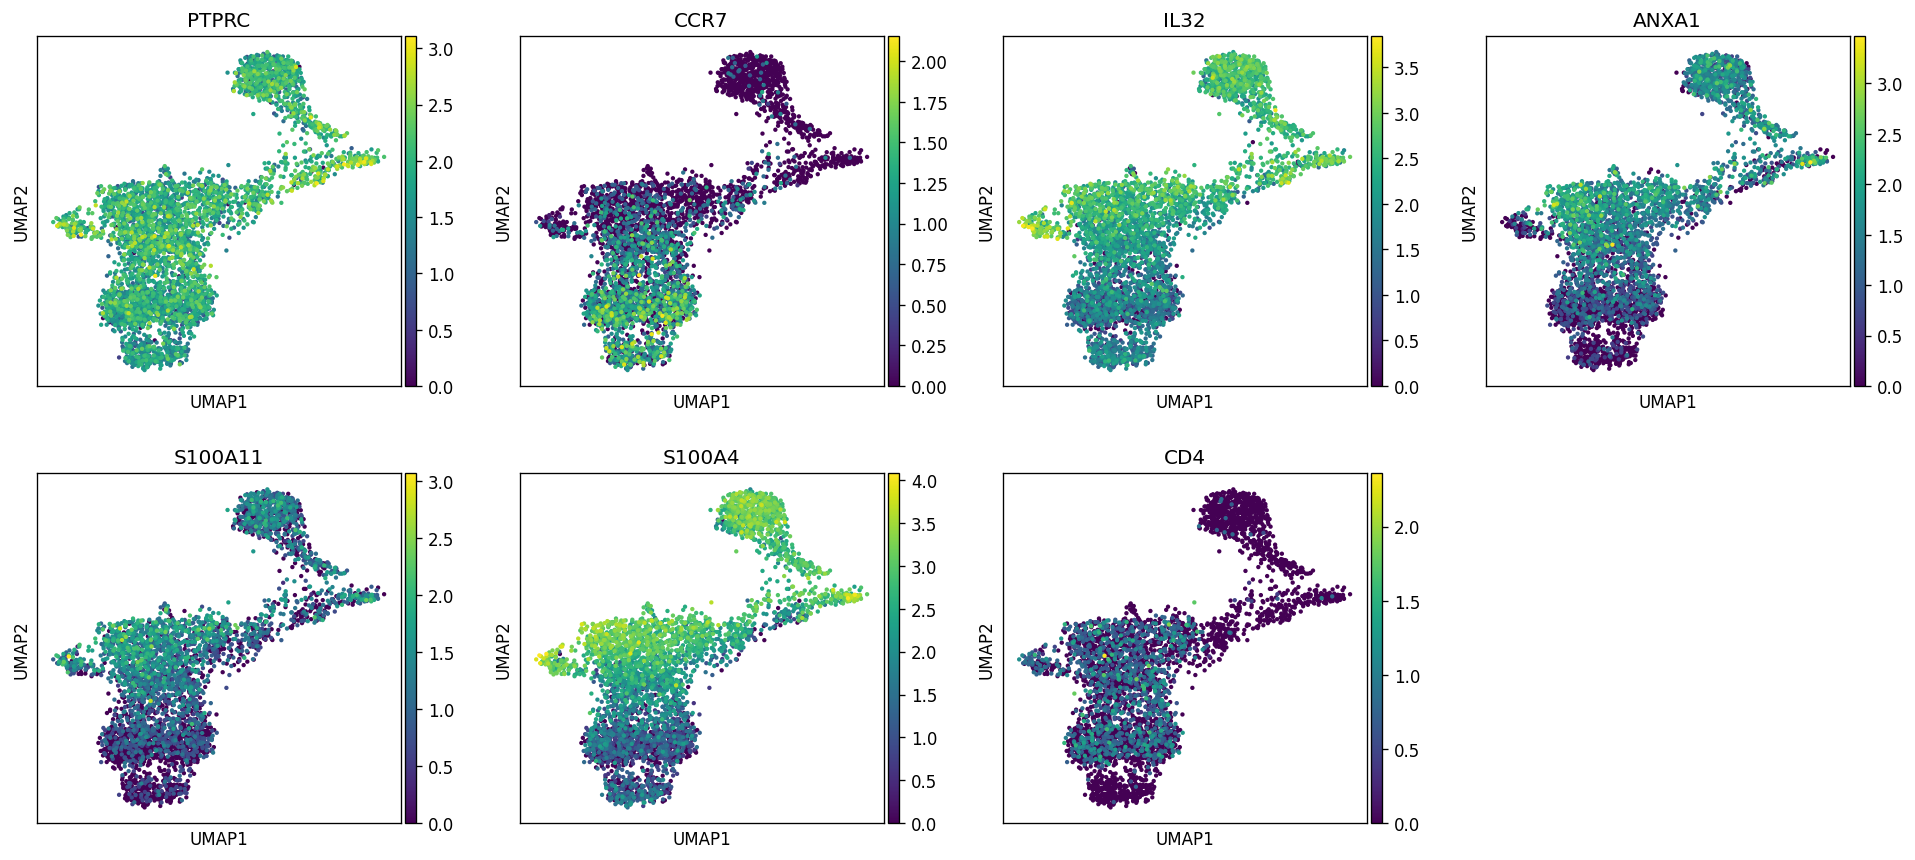

In [60]:
sc.pl.umap(
    tcells,
    color=list(
        set(
            lowlevel_markers["T Effector Cells"]
        ).union(
            set(lowlevel_markers["CD4+ Naive T Cells"])
        )
    )
)

In [61]:
lowlevel_mapping["28"] = "T Effector Cells"
lowlevel_mapping["31"] = "CD4+ Naive T Cells"

### γδ T Cells

In [62]:
lowlevel_mapping["23"] = "γδ T Cells"

### As of yet, unidentified

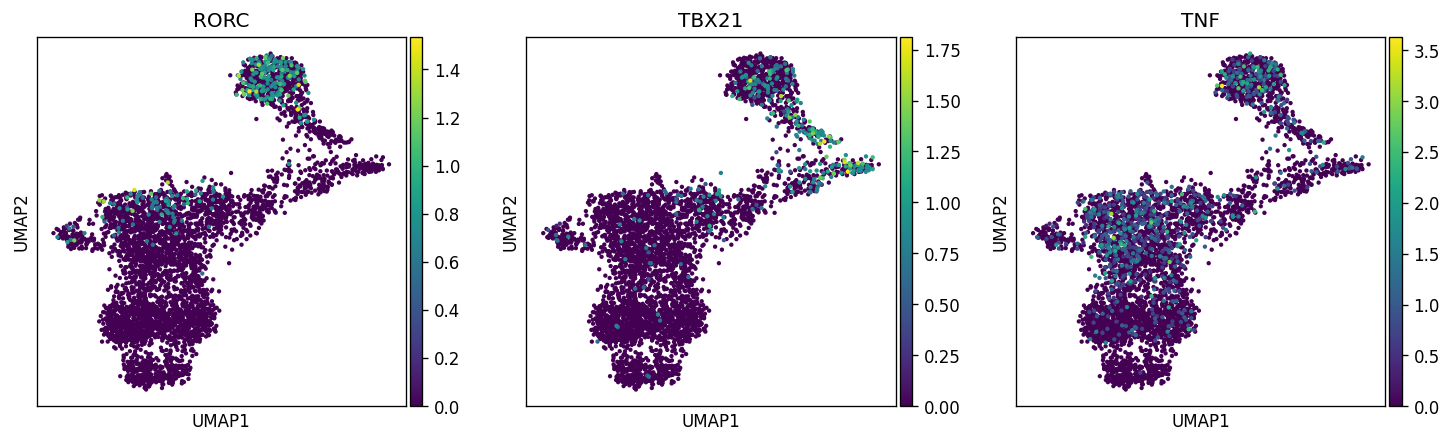

In [63]:
# Tbet: TBX21
sc.pl.umap(tcells, color=["RORC", "TBX21", "TNF"])

## B-Cells

In [64]:
bcells = pbmc[pbmc.obs["High-level celltypes"] == "B-cell"]

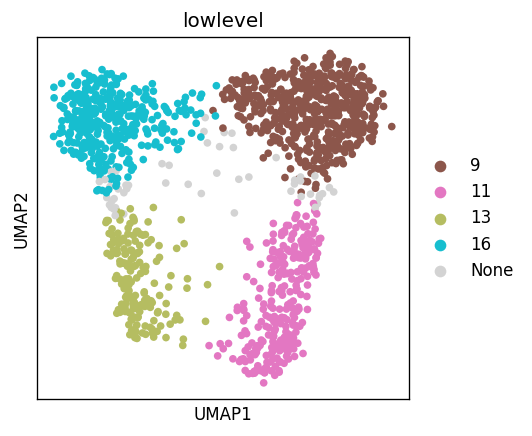

In [65]:
sc.pl.umap(bcells, color="lowlevel")

### Plasma

In [66]:
lowlevel_markers["B cells"] = [
    "CD27", # plasma
    "CD200", # germinal
    "IGKC", # Kappa Ig subunit
    "IGLC2", # Lambda Ig subunit
    "IGLC3",
]

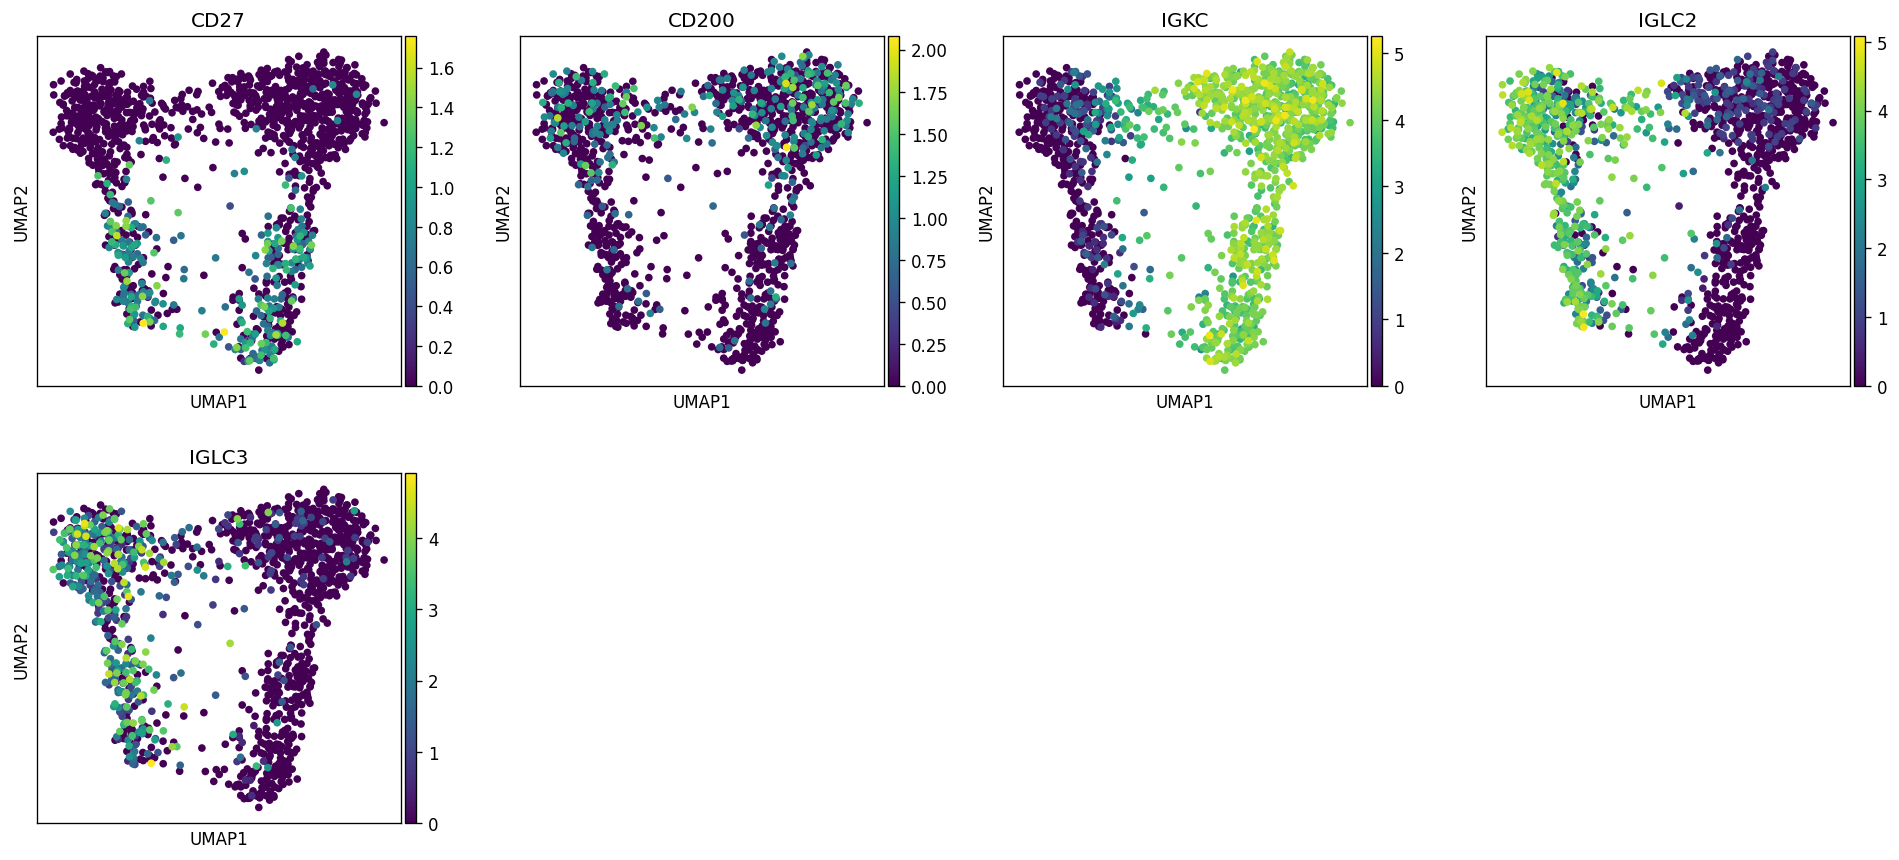

In [67]:
sc.pl.umap(bcells, color=lowlevel_markers["B cells"])

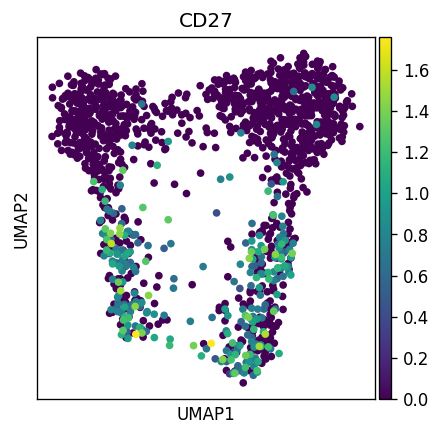

In [68]:
sc.pl.umap(bcells, color="CD27")

### Germinal

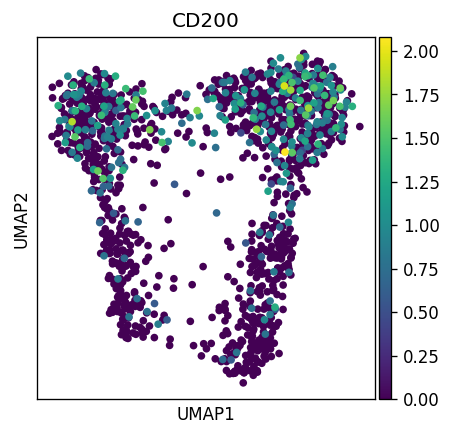

In [69]:
sc.pl.umap(bcells, color="CD200")

### Kappa Ig

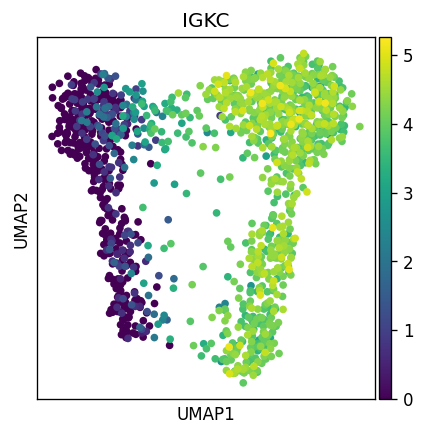

In [70]:
sc.pl.umap(bcells, color="IGKC")

### Lambda Ig

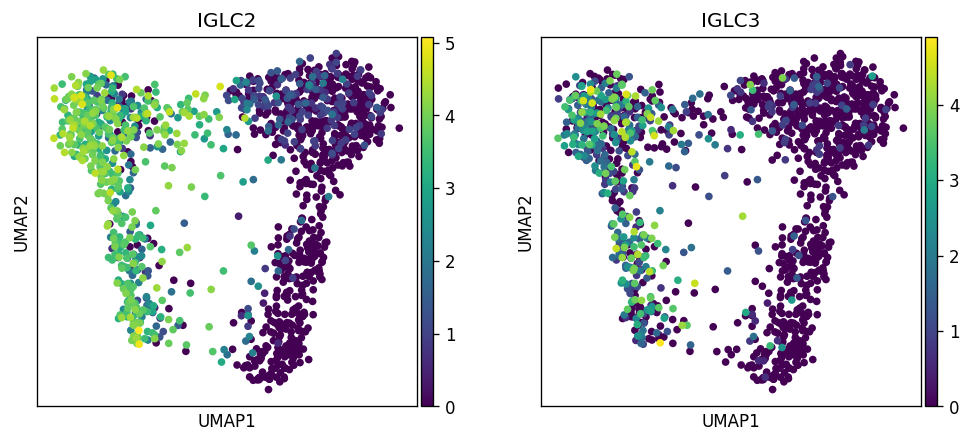

In [71]:
sc.pl.umap(bcells, color=["IGLC2", "IGLC3"])

In [72]:
lowlevel_mapping.update({
    "13": "Plasma B-cell (λ Ig subunit)",
    "11": "Plasma B-cell (κ Ig subunit)",
    "16": "Germinal B-cell (λ Ig subunit)",
    "9": "Germinal κ B-cell (κ Ig subunit)",
})

In [73]:
new_map = dict(zip(pbmc.obs["lowlevel"].cat.categories, pbmc.obs["lowlevel"].cat.categories))
new_map.update(lowlevel_mapping)

pbmc.obs["Low-level celltypes"] = pbmc.obs["lowlevel"].map(new_map)
pbmc.uns["Low-level celltypes_colors"] = pbmc.uns["lowlevel_colors"]

# Labelled figures:

## Highlevel

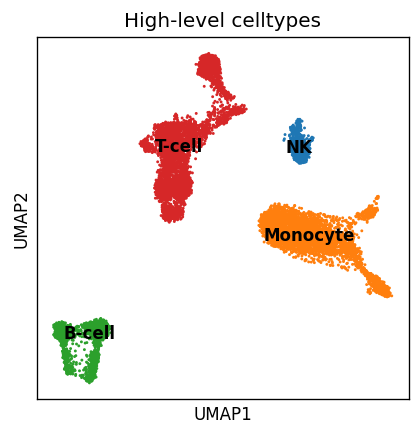

In [74]:
sc.pl.umap(pbmc, color="High-level celltypes", legend_loc="on data")

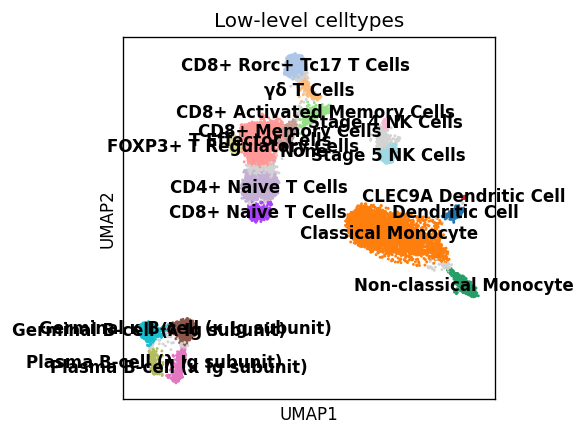

In [75]:
sc.pl.umap(pbmc, color="Low-level celltypes", legend_loc="on data")

## Lowlevel

In [76]:
from adjustText import adjust_text


def gen_mpl_labels(
    adata, groupby, exclude=(), ax=None, adjust_kwargs=None, text_kwargs=None
):
    if adjust_kwargs is None:
        adjust_kwargs = {"text_from_points": False}
    if text_kwargs is None:
        text_kwargs = {}

    medians = {}

    for g, g_idx in adata.obs.groupby(groupby).groups.items():
        if g in exclude:
            continue
        medians[g] = np.median(adata[g_idx].obsm["X_umap"], axis=0)

    if ax is None:
        texts = [
            plt.text(x=x, y=y, s=k, **text_kwargs) for k, (x, y) in medians.items()
        ]
    else:
        texts = [ax.text(x=x, y=y, s=k, **text_kwargs) for k, (x, y) in medians.items()]

    adjust_text(texts, **adjust_kwargs)

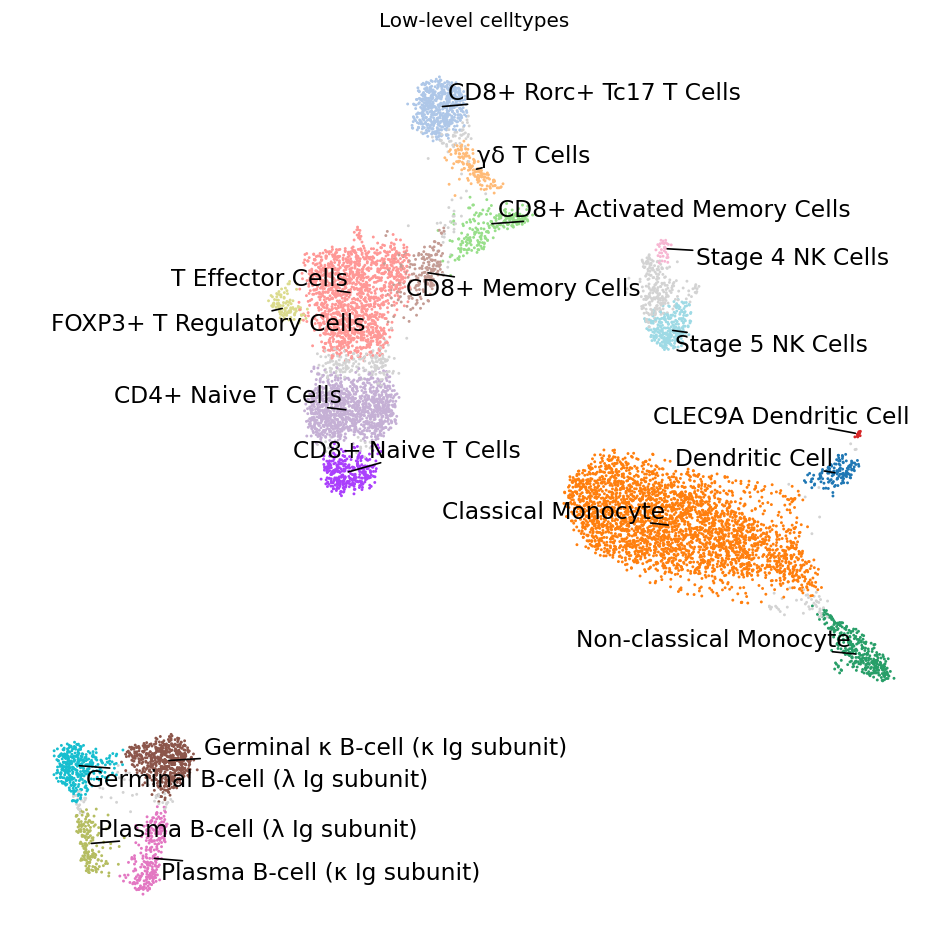

In [77]:
with plt.rc_context(
    {
        "figure.frameon": False,
        "figure.figsize": (8, 8), 
        # "figure.dpi": 300, # For export
    }
):
    ax = sc.pl.umap(
        pbmc, color="Low-level celltypes", show=False, legend_loc=None, frameon=False
    )
    gen_mpl_labels(
        pbmc,
        "Low-level celltypes",
        exclude=("None",),
        ax=ax,
        adjust_kwargs={"arrowprops": {"arrowstyle": "-", "color": "black"}},
        text_kwargs={"fontsize": 14},
    )
    fig = ax.get_figure()
    fig.tight_layout()
    #     plt.savefig("./low-level_labels.svg")
    #     plt.savefig("./low-level_labels.jpeg")
    plt.show()

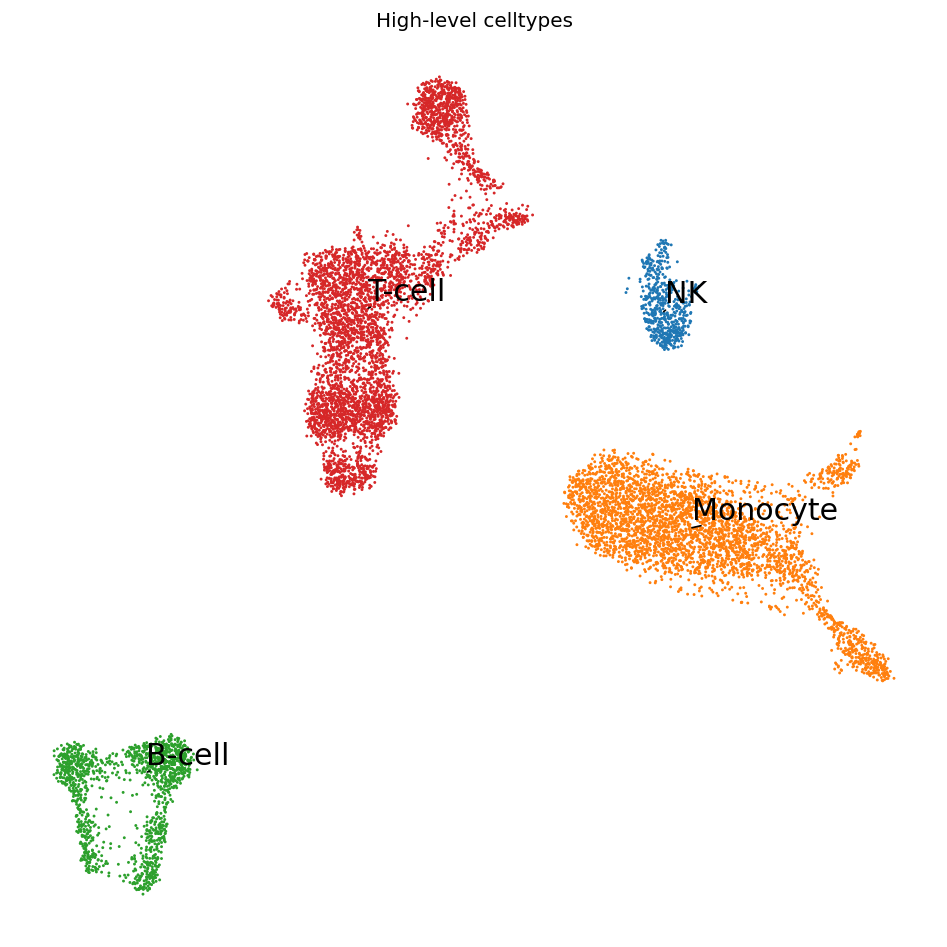

In [78]:
with plt.rc_context(
    {
        "figure.frameon": False,
        "figure.figsize": (8, 8),
        # "figure.dpi": 300, # For export
    }
):
    ax = sc.pl.umap(pbmc, color="High-level celltypes", show=False, legend_loc=None, frameon=False)
    gen_mpl_labels(
        pbmc,
        "High-level celltypes",
        exclude=("None",),
        ax=ax,
        adjust_kwargs=dict(arrowprops=dict(arrowstyle='-', color='black')),
        text_kwargs=dict(fontsize=18),
    )
    fig = ax.get_figure()
    fig.tight_layout()
#     plt.savefig("./high-level_labels.svg")
#     plt.savefig("./high-level_labels.jpeg")
    plt.show()

# Marker genes

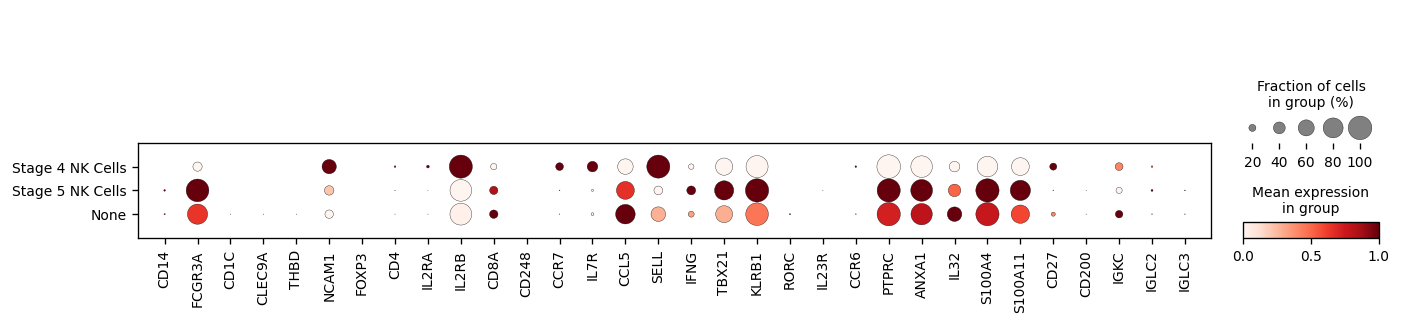

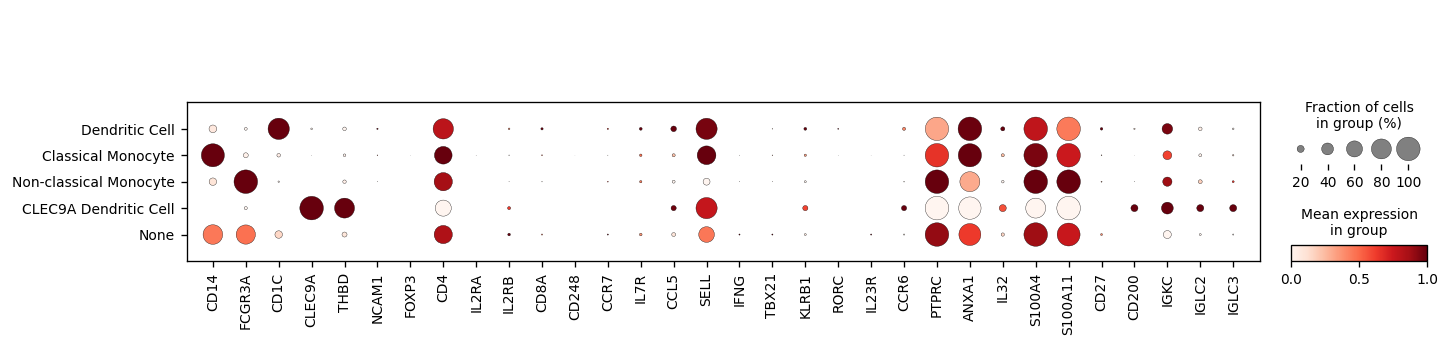

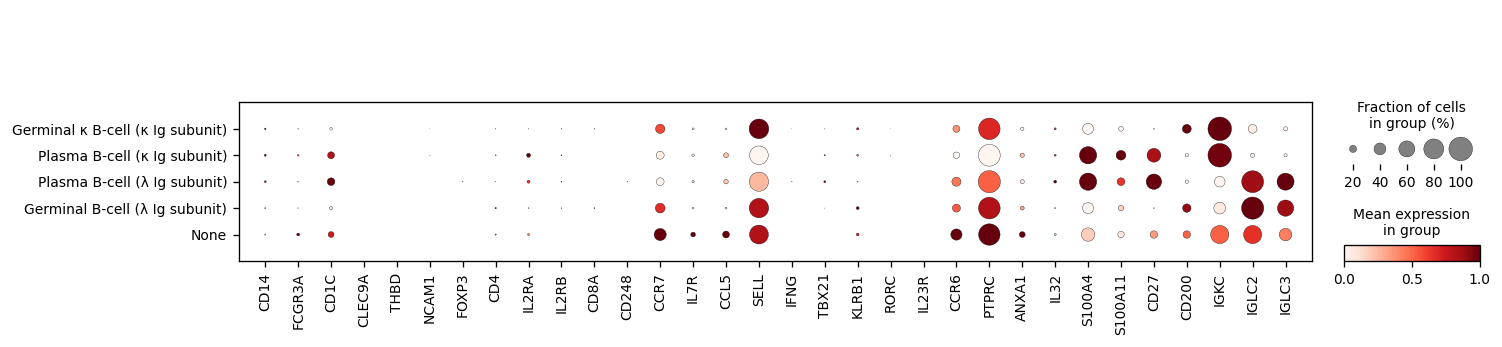

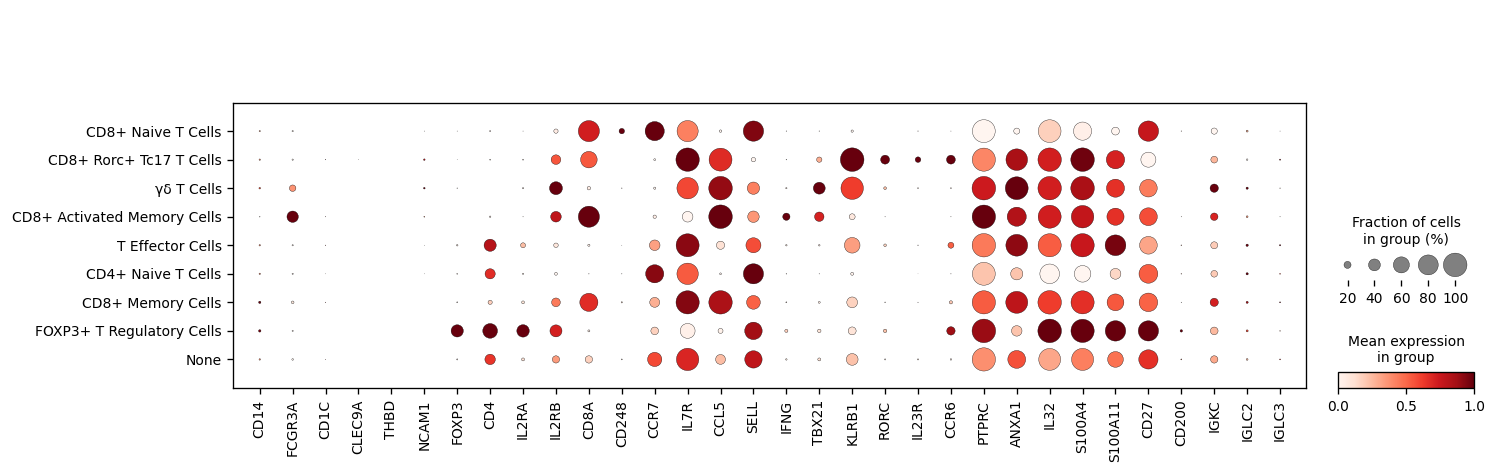

In [79]:
from itertools import chain

for highlevel, indices in pbmc.obs.groupby("High-level celltypes").indices.items():
    sub_adata = pbmc[indices, :]
    sc.pl.dotplot(
        sub_adata,
        var_names=pd.unique(list(chain.from_iterable(lowlevel_markers.values()))),
        groupby="Low-level celltypes",
        standard_scale="var",
    )
    plt.show()

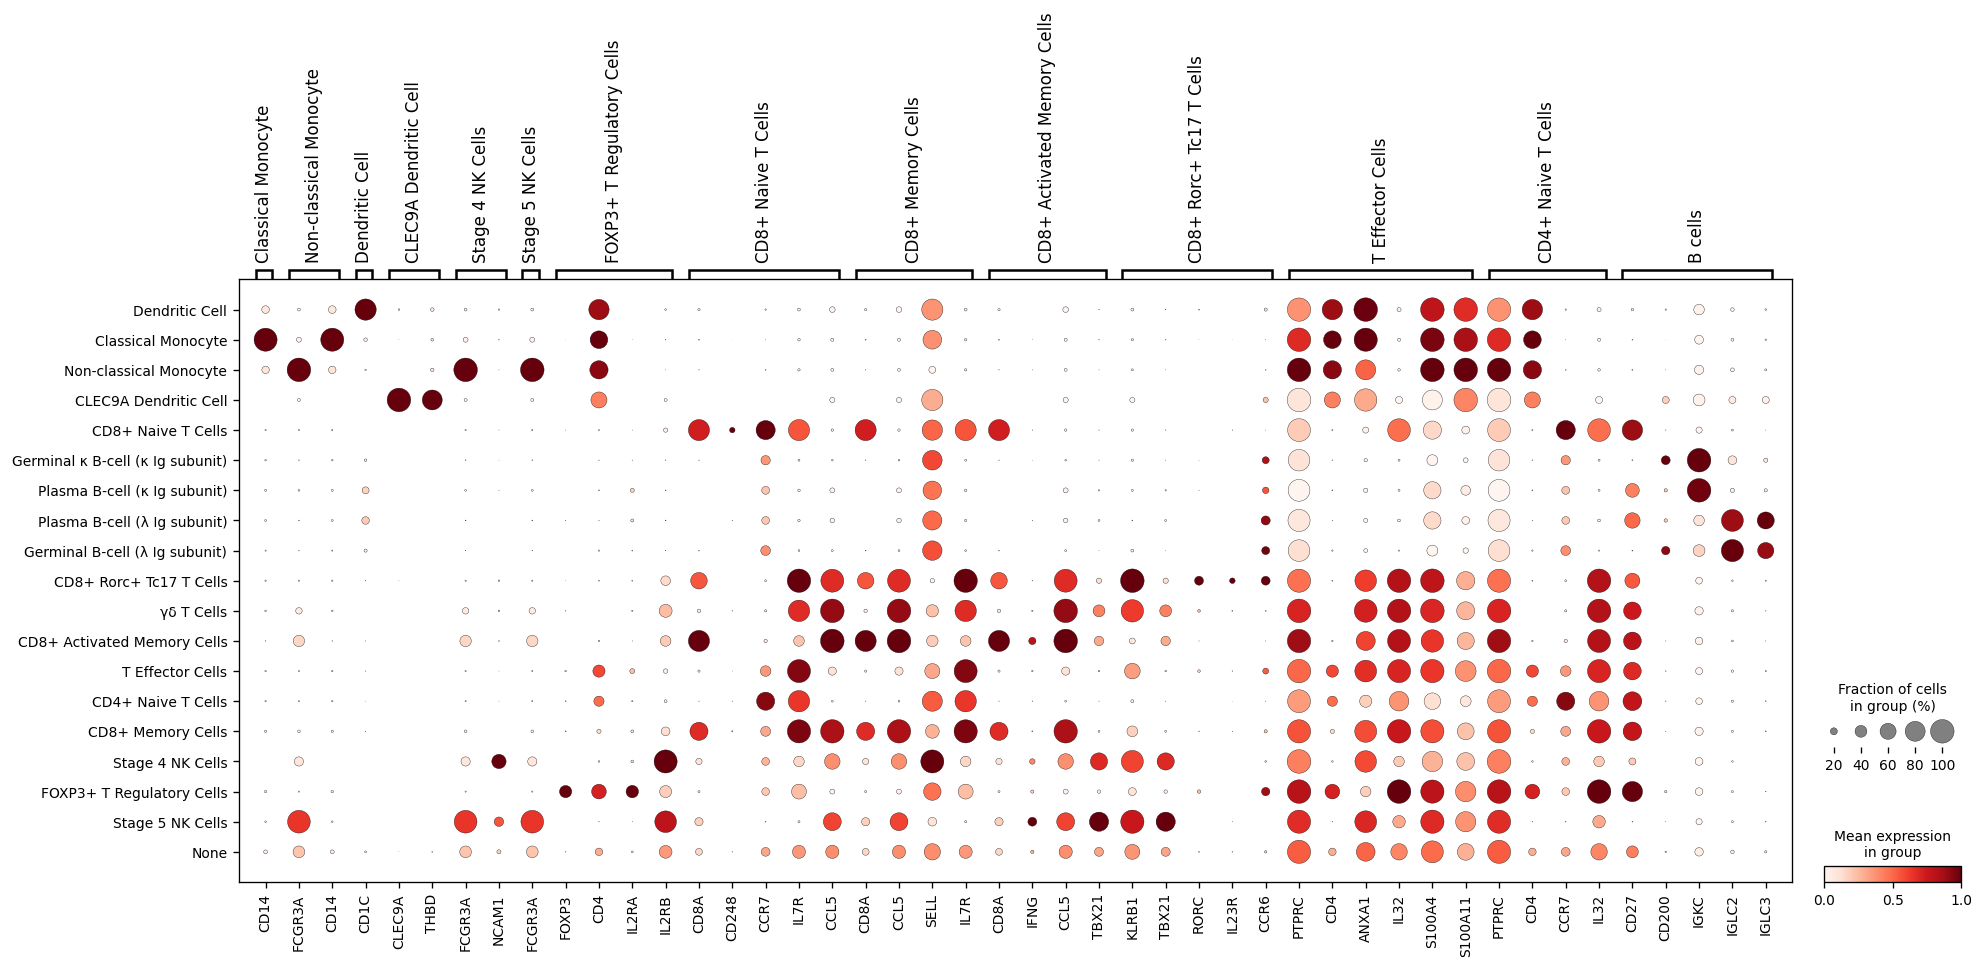

In [80]:
sc.pl.dotplot(
    pbmc,
    lowlevel_markers,
    groupby="Low-level celltypes",
    standard_scale="var",
)
plt.show()

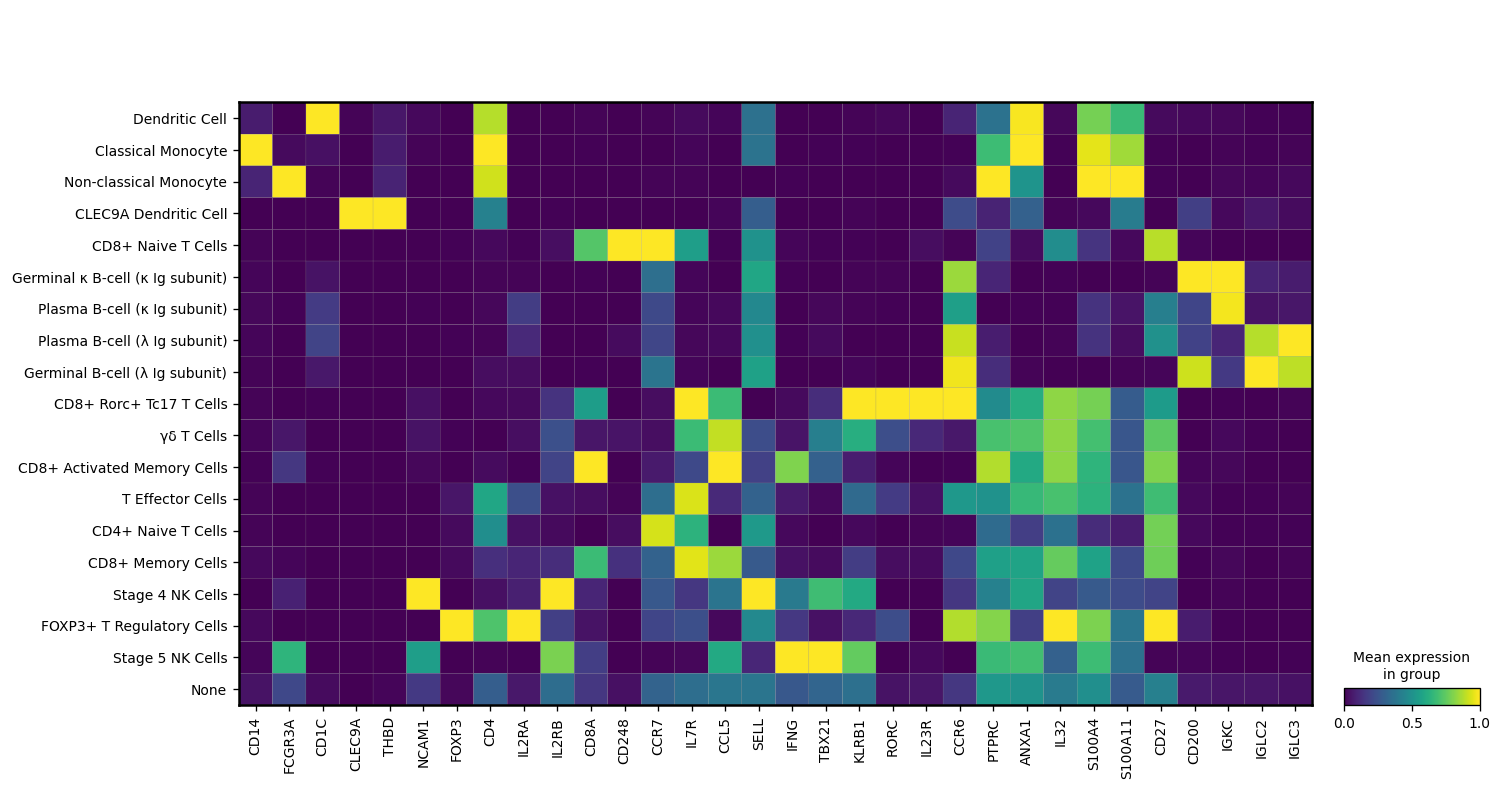

In [81]:
from itertools import chain
sc.pl.matrixplot(
    pbmc,
    var_names=pd.unique(list(chain.from_iterable(lowlevel_markers.values()))),
    groupby="Low-level celltypes",
    standard_scale="var"
)

In [82]:
# pbmc.write_h5ad("./data/pbmc-labelled.h5ad", compression="lzf")

In [ ]:
from sinfo import sinfo

sinfo()